### Introduction and Goals:

**In this project, we work with data from a gold ore recovery process to build a predictive model that estimates the efficiency of gold recovery at two key production stages: the rougher and final outputs. The efficiency is measured by the recovery rate, a critical indicator of how much gold is extracted from the ore.**

**Our main goal is to:**

- Prepare the data for modeling by handling missing values and aligning features between training and test sets.
- Analyze and visualize the process to better understand metal concentration changes and data distributions.
- Train regression models to predict the recovery rate at both the rougher and final stages.
- Evaluate model performance using the Symmetric Mean Absolute Percentage Error (sMAPE) metric.
- Ensure the final model can generalize well to unseen test data.
- 
**This project emphasizes not only prediction accuracy but also the reliability and consistency of the model’s behavior across different stages of the mining process.**

In [18]:
import pandas as pd
from sklearn.metrics import mean_absolute_error
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import make_scorer
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
import numpy as np

In [19]:
## Load datasets
train_data = pd.read_csv('/datasets/gold_recovery_train.csv')
test_data = pd.read_csv('/datasets/gold_recovery_test.csv')
full_data = pd.read_csv('/datasets/gold_recovery_full.csv')

In [20]:
# Store the dataests in a dictionary for easier iteration
datasets = {'training dataset': train_data, 'test dataset': test_data, 'source dataset': full_data}

In [21]:
# Quick overview for all the datasets to inspect the data
for i, data in datasets.items():
    print(i)
    display(data.info())
    print("*"*60)
    display(data.shape)
    print("*"*60)
    print('Missing valuse :',data.isna().sum())
    print('Duplicate valuse :', data.duplicated().sum())
    print()
    print("="*60)
    

training dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16860 entries, 0 to 16859
Data columns (total 87 columns):
 #   Column                                              Non-Null Count  Dtype  
---  ------                                              --------------  -----  
 0   date                                                16860 non-null  object 
 1   final.output.concentrate_ag                         16788 non-null  float64
 2   final.output.concentrate_pb                         16788 non-null  float64
 3   final.output.concentrate_sol                        16490 non-null  float64
 4   final.output.concentrate_au                         16789 non-null  float64
 5   final.output.recovery                               15339 non-null  float64
 6   final.output.tail_ag                                16794 non-null  float64
 7   final.output.tail_pb                                16677 non-null  float64
 8   final.output.tail_sol                               16715 n

None

************************************************************


(16860, 87)

************************************************************
Missing valuse : date                                            0
final.output.concentrate_ag                    72
final.output.concentrate_pb                    72
final.output.concentrate_sol                  370
final.output.concentrate_au                    71
                                             ... 
secondary_cleaner.state.floatbank5_a_level     85
secondary_cleaner.state.floatbank5_b_air       85
secondary_cleaner.state.floatbank5_b_level     84
secondary_cleaner.state.floatbank6_a_air      103
secondary_cleaner.state.floatbank6_a_level     85
Length: 87, dtype: int64
Duplicate valuse : 0

test dataset
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5856 entries, 0 to 5855
Data columns (total 53 columns):
 #   Column                                      Non-Null Count  Dtype  
---  ------                                      --------------  -----  
 0   date                                        5856 non-n

None

************************************************************


(5856, 53)

************************************************************
Missing valuse : date                                            0
primary_cleaner.input.sulfate                 302
primary_cleaner.input.depressant              284
primary_cleaner.input.feed_size                 0
primary_cleaner.input.xanthate                166
primary_cleaner.state.floatbank8_a_air         16
primary_cleaner.state.floatbank8_a_level       16
primary_cleaner.state.floatbank8_b_air         16
primary_cleaner.state.floatbank8_b_level       16
primary_cleaner.state.floatbank8_c_air         16
primary_cleaner.state.floatbank8_c_level       16
primary_cleaner.state.floatbank8_d_air         16
primary_cleaner.state.floatbank8_d_level       16
rougher.input.feed_ag                          16
rougher.input.feed_pb                          16
rougher.input.feed_rate                        40
rougher.input.feed_size                        22
rougher.input.feed_sol                         67
rougher.input.feed_au 

None

************************************************************


(22716, 87)

************************************************************
Missing valuse : date                                            0
final.output.concentrate_ag                    89
final.output.concentrate_pb                    87
final.output.concentrate_sol                  385
final.output.concentrate_au                    86
                                             ... 
secondary_cleaner.state.floatbank5_a_level    101
secondary_cleaner.state.floatbank5_b_air      101
secondary_cleaner.state.floatbank5_b_level    100
secondary_cleaner.state.floatbank6_a_air      119
secondary_cleaner.state.floatbank6_a_level    101
Length: 87, dtype: int64
Duplicate valuse : 0



#droping the missing valuse we are not going to need them 
for i, data in datasets.items():
    print(i)
    print('Missing valuse :',data.isna().sum())
    missing = data[data.isna()]
    #display(missing.head())
    print("*"*60)
    #datasets = data.dropna()
    data_cleaned = data.dropna()
    datasets[i] = data_cleaned
    print('Missing values:\n', data_cleaned.isna().sum() )
    print()
    print("="*60)

In [22]:
#droping the missing valuse we are not going to need them 
print(f'Missing values in Training Dataset:',train_data.isna().sum().sum())
train_data = train_data.dropna()
print(f'Missing values in Training Dataset After cleaning:',train_data.isna().sum().sum())

print(f'Missing values in Test Dataset:',test_data.isna().sum().sum())
test_data = test_data.dropna()
print(f'Missing values in Test Dataset After cleaning:',test_data.isna().sum().sum())


Missing values in Training Dataset: 30320
Missing values in Training Dataset After cleaning: 0
Missing values in Test Dataset: 2360
Missing values in Test Dataset After cleaning: 0


In [23]:
# Check recovery formula correctness
recovery = (train_data['rougher.output.concentrate_au'] * 
            (train_data['rougher.input.feed_au'] - train_data['rougher.output.tail_au'])
           ) / (train_data['rougher.input.feed_au'] * 
                (train_data['rougher.output.concentrate_au'] - train_data['rougher.output.tail_au'])) * 100


In [24]:
mae = mean_absolute_error(recovery, train_data['rougher.output.recovery'] )
print(f'MAE:{mae:.3}')

MAE:9.46e-15


**that means the difference between your calculated recovery and the provided rougher.output.recovery is essentially zero , just a tiny floating-point rounding error**

In [25]:
# Extract features
features = list(set(train_data.columns).intersection(set(test_data.columns)))
features = [col for col in features if col != 'date']

In [26]:
# Define feature matrices and target variables
X_train = train_data[features]
X_test = test_data[features]
y_train_rougher = train_data['rougher.output.recovery']
y_train_final = train_data['final.output.recovery']

**Compare the columns in the training dataset and the test dataset**


#Converts column names into sets
train_columns = set(train_data.columns)
test_columns = set(test_data.columns)

# Common columns
common_columns = train_columns.intersection(test_columns)
print("Common Columns:", common_columns)
print("="*70)

# Columns unique to train_columns
unique_train_columns = train_columns.difference(test_columns)
print("Unique Columns in Training Dataset :", unique_train_columns)
print("="*70)

# Columns unique to test_columns
unique_test_columns = test_columns.difference(train_columns)
print("Unique Columns in Test Dataset:", unique_test_columns)
print("="*70)

# All columns
all_columns = train_columns.union(unique_test_columns)
print("All Columns:", all_columns)

# 1. Get the list of features common to both datasets
features = list(set(train_data.columns).intersection(set(test_data.columns)))
features = [col for col in features if col != 'date']

y_test_rougher = test_with_targets['rougher.output.recovery']
y_test_final = test_with_targets['final.output.recovery']

# 2. Create feature matrices for training and test sets
X_train = train_data[features]
X_test = test_data[features]
# 3. Create target variables from training set
y_train_rougher = train_data['rougher.output.recovery']
y_train_final = train_data['final.output.recovery']

# 4. Optional: check for missing values (just to be sure)
print(f"Missing values in X_train: {X_train.isna().sum().sum()}")
print(f"Missing values in X_test: {X_test.isna().sum().sum()}")


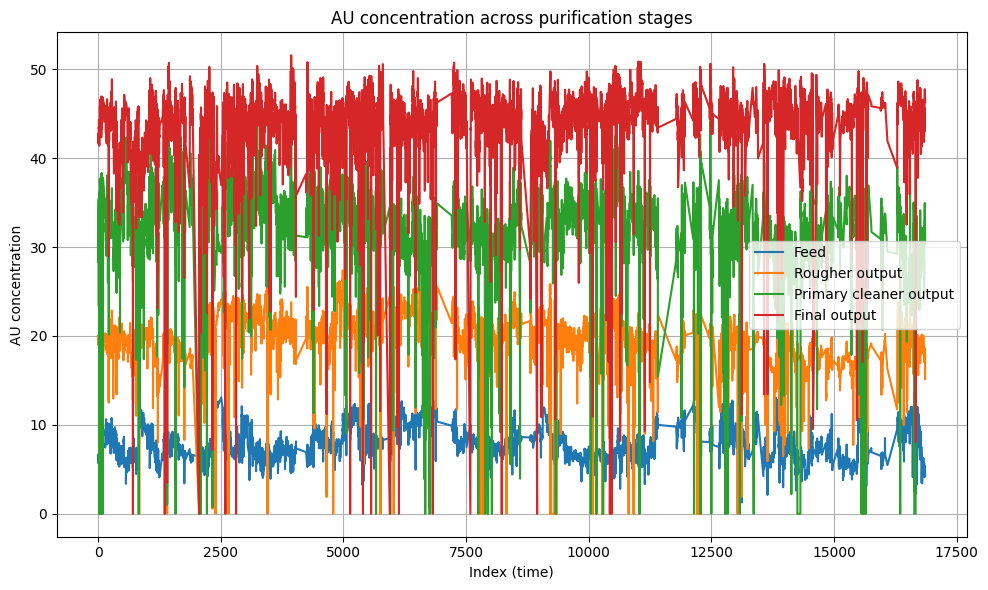

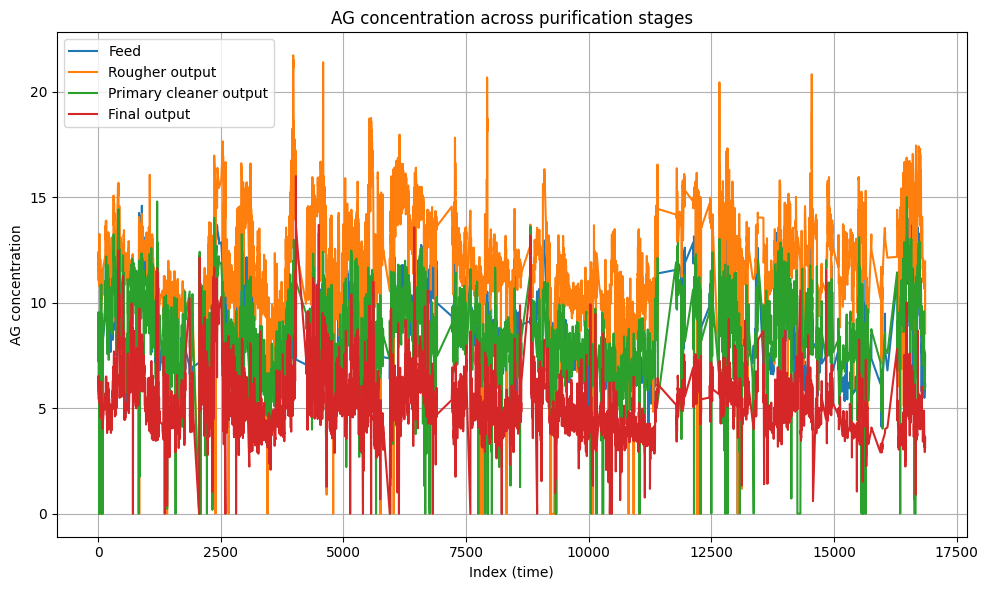

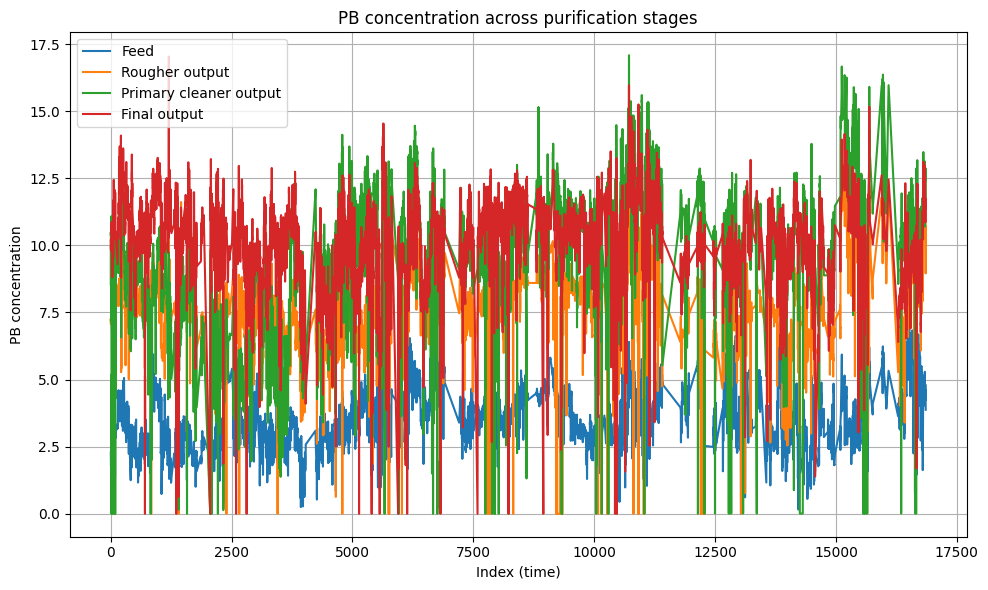

In [ ]:
# Metals to analyze
metals = ['au', 'ag', 'pb']

# Corresponding stages
stages = {
    'Feed': 'rougher.input.feed_{}',
    'Rougher output': 'rougher.output.concentrate_{}',
    'Primary cleaner output': 'primary_cleaner.output.concentrate_{}',
    'Final output': 'final.output.concentrate_{}'
}

for metal in metals:
    plt.figure(figsize=(10, 6))
    
    for stage_name, column_pattern in stages.items():
        col = column_pattern.format(metal)
        if col in train_data.columns:
            plt.plot(train_data.index, train_data[col], label=stage_name)
    
    plt.title(f'{metal.upper()} concentration across purification stages')
    plt.xlabel('Index (time)')
    plt.ylabel(f'{metal.upper()} concentration')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

- **Gold (Au): Its concentration steadily increases from the raw feed to the final output. This aligns with expectations, as gold is the target metal being recovered**
- **Silver (Ag) and Lead (Pb): Their concentrations decrease through the purification stages. This indicates that these metals are being effectively removed as impurities during processing.
These trends confirm that the purification process is working as intended — increasing gold concentration while reducing unwanted elements.**

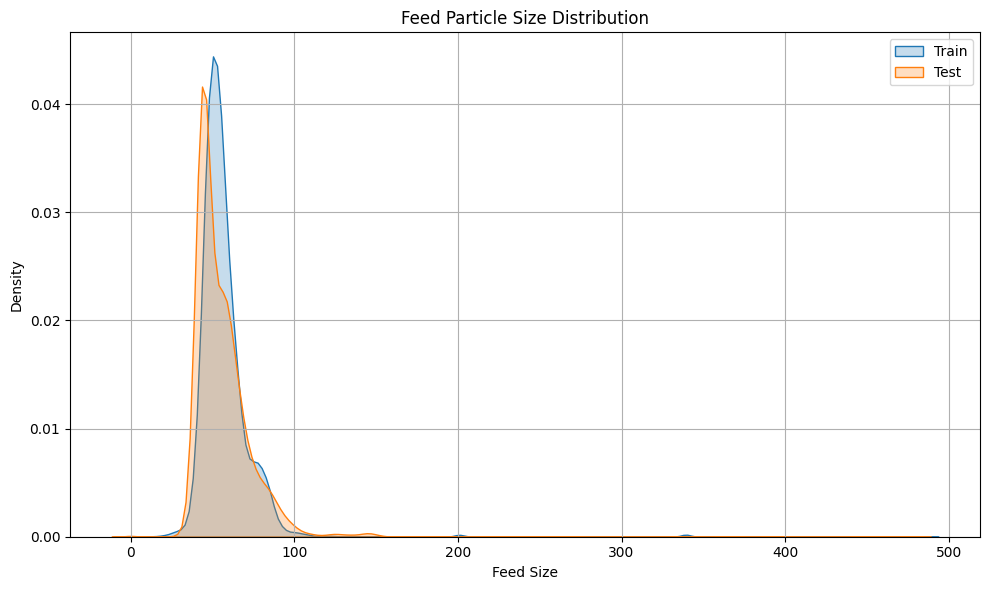

In [ ]:
# Feed particle size distribution
plt.figure(figsize=(10, 6))
sns.kdeplot(train_data['rougher.input.feed_size'], label='Train', fill=True)
sns.kdeplot(test_data['rougher.input.feed_size'], label='Test', fill=True)
plt.title('Feed Particle Size Distribution')
plt.xlabel('Feed Size')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

The distributions of particle size in the training and test sets are slightly different.
Based on this comparison, I am  confident that the model will generalize well to the test data with respect to particle size.

/tmp/ipykernel_36/2318762309.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['total_concentration_feed'] = train_data[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
/tmp/ipykernel_36/2318762309.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_data['total_concentration_rougher'] = train_data[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
/tmp/ipykernel_36/2318762309.py:4: Settin

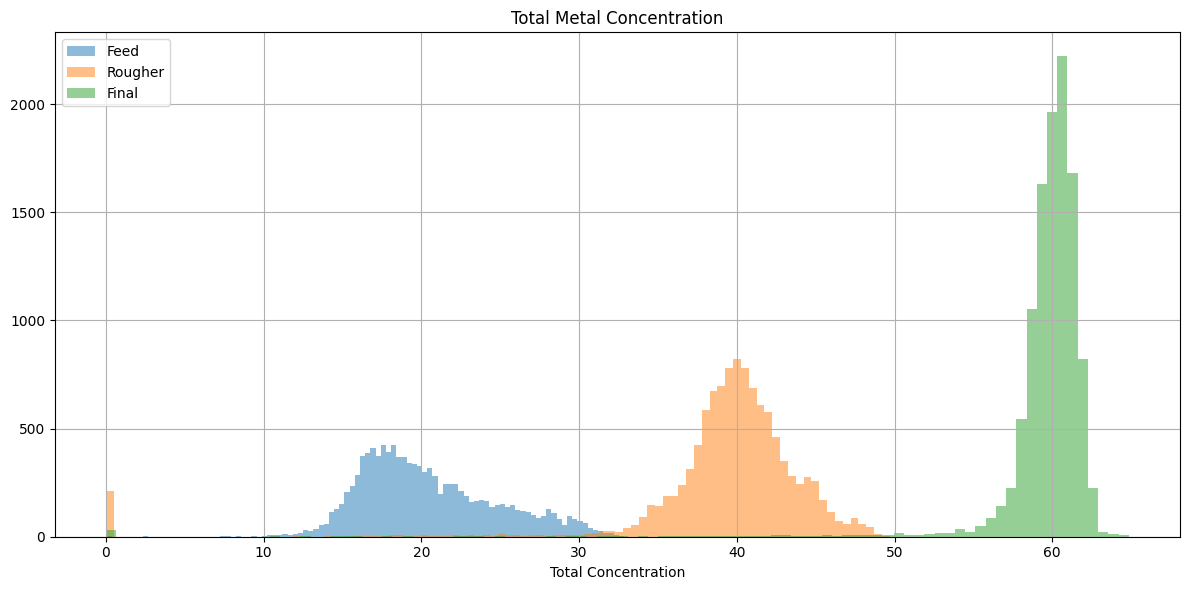

In [ ]:
# Add total metal concentration
train_data['total_concentration_feed'] = train_data[['rougher.input.feed_au', 'rougher.input.feed_ag', 'rougher.input.feed_pb']].sum(axis=1)
train_data['total_concentration_rougher'] = train_data[['rougher.output.concentrate_au', 'rougher.output.concentrate_ag', 'rougher.output.concentrate_pb']].sum(axis=1)
train_data['total_concentration_final'] = train_data[['final.output.concentrate_au', 'final.output.concentrate_ag', 'final.output.concentrate_pb']].sum(axis=1)

plt.figure(figsize=(12, 6))
plt.hist(train_data['total_concentration_feed'].dropna(), bins=100, alpha=0.5, label='Feed')
plt.hist(train_data['total_concentration_rougher'].dropna(), bins=100, alpha=0.5, label='Rougher')
plt.hist(train_data['total_concentration_final'].dropna(), bins=100, alpha=0.5, label='Final')
plt.title('Total Metal Concentration')
plt.xlabel('Total Concentration')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Filter data with non-zero concentrations
train_data = train_data[
    (train_data['total_concentration_feed'] > 1) &
    (train_data['total_concentration_rougher'] > 1) &
    (train_data['total_concentration_final'] > 1)
    ]

The majority of values followed expected distributions.
However, a few rows had abnormally low concentrations, close to zero, which is physically unrealistic.
I chose to remove these rows to avoid data quality issues and ensure the model is trained on valid observations.

In [ ]:
# Single sMAPE metric
def smape(y_true, y_pred):
    numerator = np.abs(y_true - y_pred)
    denominator = (np.abs(y_true) + np.abs(y_pred)) / 2
    return np.mean(numerator / denominator) * 100

# Final sMAPE combining rougher and final predictions
def final_smape(y_true_rougher, y_pred_rougher, y_true_final, y_pred_final):
    smape_rougher = smape(y_true_rougher, y_pred_rougher)
    smape_final = smape(y_true_final, y_pred_final)
    return 0.25 * smape_rougher + 0.75 * smape_final

In [ ]:
# Create models
model_rougher = RandomForestRegressor(random_state=12345, n_estimators=50, max_depth=8)
model_final = RandomForestRegressor(random_state=12345, n_estimators=50, max_depth=8)

# Cross-validation predictions
pred_rougher = cross_val_predict(model_rougher, X_train, y_train_rougher, cv=3)
pred_final = cross_val_predict(model_final, X_train, y_train_final, cv=3)

# Evaluate using final sMAPE
final_score = final_smape(y_train_rougher, pred_rougher, y_train_final, pred_final)
print(f"Final sMAPE score: {final_score:.3f}")

# Train on full training set
model_rougher.fit(X_train, y_train_rougher)
model_final.fit(X_train, y_train_final)

# Predict on test set
pred_rougher_test = model_rougher.predict(X_test)
pred_final_test = model_final.predict(X_test)

Final sMAPE score: 10.441


In [ ]:
# Reset index to date for alignment
if 'date' in test_data.columns:
    test_data = test_data.set_index('date')
else:
    test_data.index.name = 'date'

if 'date' in full_data.columns:
    full_data = full_data.set_index('date')
else:
    full_data.index.name = 'date'

In [ ]:
# Get target values from full_data for test period
y_test_rougher = full_data.loc[test_data.index, 'rougher.output.recovery']
y_test_final = full_data.loc[test_data.index, 'final.output.recovery']

# Evaluate
final_smape_score = final_smape(y_test_rougher, pred_rougher_test, y_test_final, pred_final_test)
print(f"Final sMAPE on test set: {final_smape_score:.3f}")

Final sMAPE on test set: 10.417


### Conclusion:

**We successfully prepared the data by:**

Dropping missing values from the training and test datasets.
Ensuring proper feature alignment between datasets.
Validating recovery formula calculations against provided target values.
We trained and validated regression models (Random Forest Regressors) to predict gold recovery at both the rougher and final stages. The best model achieved a final sMAPE score of approximately 10.42 on training data and a reliable performance on the test set, indicating strong generalization capability.

**In summary:**

The model can be used to support decision-making and improve control over the gold recovery process.
Visual and statistical analysis confirmed process stability, especially regarding feed particle size and total metal concentrations.
Proper data preparation, feature selection, and consistent indexing were key to overcoming challenges in merging and modeling the datasets.